In [235]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.utils import resample

from sklearn.inspection import permutation_importance

from sklearn.neighbors import NearestNeighbors



In [282]:
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Add this after your existing preprocessing code
demographic_stats = df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Coverage (%)': ['mean', 'median', 'std']
})




In [237]:
# ==============================================
# THEME ANALYSIS (existing code)
# ==============================================
# Count themes and sort in descending order
theme_counts = df.groupby(['Country', 'Theme']).size().unstack().fillna(0)
theme_counts = theme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Calculate percentages and sort in descending order
theme_percentages = theme_counts.div(theme_counts.sum(axis=1), axis=0) * 100
theme_percentages = theme_percentages.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Get top themes for each country (already sorted in descending order)
us_top_themes = theme_counts.loc['United States'].sort_values(ascending=False)
canada_top_themes = theme_counts.loc['Canada'].sort_values(ascending=False)

# ==============================================
# SUB-THEME ANALYSIS (new code)
# ==============================================
# 1. Count sub-theme frequencies by country and sort in descending order
subtheme_counts = df.groupby(['Country', 'Theme', 'Sub-theme']).size().unstack().fillna(0)
subtheme_counts = subtheme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 2. Calculate percentages and sort in descending order
subtheme_percentages = subtheme_counts.div(subtheme_counts.sum(axis=1), axis=0) * 100
subtheme_percentages = subtheme_percentages.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 3. Get top sub-themes for each country (already sorted in descending order)
us_top_subthemes = df[df['Country']=='United States']['Sub-theme'].value_counts()
canada_top_subthemes = df[df['Country']=='Canada']['Sub-theme'].value_counts()

# ==============================================
# PRINT COMBINED RESULTS (all sorted descending)
# ==============================================
# ==============================================
# THEME ANALYSIS - SORTED PROPERLY
# ==============================================
# Count themes
theme_counts = df.groupby(['Country', 'Theme']).size().unstack().fillna(0)

# Sort each row (country) in descending order
theme_counts = theme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Transpose to get themes as rows and countries as columns for better readability
theme_counts_sorted = theme_counts.T.sort_values(by=['United States', 'Canada'], ascending=False)

# Calculate percentages (sorted to match counts)
theme_percentages = (theme_counts_sorted / theme_counts_sorted.sum()) * 100

# ==============================================
# PRINT RESULTS
# ==============================================
print("="*50)
print("THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)")
print("="*50)
print(theme_counts_sorted)
print("\n")

print("="*50)
print("THEME DISTRIBUTION BY COUNTRY (PERCENTAGE - DESCENDING ORDER)")
print("="*50)
print(theme_percentages.round(1))
print("\n")

print("="*50)
print("SUB-THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)")
print("="*50)
print(subtheme_counts)
print("\n")


print("="*50)
print("TOP 5 SUB-THEMES IN UNITED STATES (DESCENDING ORDER)")
print("="*50)
print(us_top_subthemes.head(5))
print("\n")

print("="*50)
print("TOP 5 SUB-THEMES IN CANADA (DESCENDING ORDER)")
print("="*50)
print(canada_top_subthemes.head(5))
print("\n")

THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)
Country                                             Canada  United States
Theme                                                                    
Structural, Information, and Systematic Barrier...      66             70
Reluctance to use EAP Services due to Psychosoc...      70             40
Service Quality, Scope and Cultural Relevance t...      19             30


THEME DISTRIBUTION BY COUNTRY (PERCENTAGE - DESCENDING ORDER)
Country                                             Canada  United States
Theme                                                                    
Structural, Information, and Systematic Barrier...    42.6           50.0
Reluctance to use EAP Services due to Psychosoc...    45.2           28.6
Service Quality, Scope and Cultural Relevance t...    12.3           21.4


SUB-THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)
Sub-theme                                                         Awareness 

In [218]:
# 5. Demographic breakdown by theme and country
print("="*50)
print("DEMOGRAPHIC PROFILE BY THEME AND COUNTRY")
print("="*50)
demographic_by_theme_country = df.groupby(['Country', 'Theme']).agg({
    'Age': ['mean', 'median', 'count'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})
demographic_by_theme_country

DEMOGRAPHIC PROFILE BY THEME AND COUNTRY


Age  \
                                                                       mean   
Country       Theme                                                           
Canada        Reluctance to use EAP Services due to Psychosoc...  37.214286   
              Service Quality, Scope and Cultural Relevance t...  39.000000   
              Structural, Information, and Systematic Barrier...  37.469697   
United States Reluctance to use EAP Services due to Psychosoc...  42.775000   
              Service Quality, Scope and Cultural Relevance t...  37.800000   
              Structural, Information, and Systematic Barrier...  40.842857   

                                                                               \
                                                                 median count   
Country       Theme                                                             
Canada        Reluctance to use EAP Services due to Psychosoc...   32.0    70   
              Service Quality, Scope and Cultural Relevance t...   36.0    19   
              Structural, Information, and Systematic Barrier...   34.0    66   
United States Reluctance to use EAP Services due to Psychosoc...   47.0    40   
              Service Quality, Scope and Cultural Relevance t...   36.5    30   
              Structural, Information, and Systematic Barrier...   46.0    70   

                                                                                                             Gender  
                                                                                                           <lambda>  
Country       Theme                                                                                                  
Canada        Reluctance to use EAP Services due to Psychosoc...                       {'male': 0.7, 'female': 0.3}  
              Service Quality, Scope and Cultural Relevance t...  {'male': 0.5263157894736842, 'female': 0.47368...  
              Structural, Information, and Systematic Barrier...  {'male': 0.6515151515151515, 'female': 0.34848...  
United States Reluctance to use EAP Services due to Psychosoc...                   {'female': 0.875, 'male': 0.125}  
              Service Quality, Scope and Cultural Relevance t...                       {'female': 0.7, 'male': 0.3}  
              Structural, Information, and Systematic Barrier...  {'female': 0.8142857142857143, 'male': 0.18571...

In [219]:
# 5. Demographic breakdown by theme and country
print("="*50)
print("DEMOGRAPHIC PROFILE BY SUB-THEME AND COUNTRY")
print("="*50)
demographic_by_theme_country = df.groupby(['Country', 'Sub-theme']).agg({
    'Age': ['mean', 'median', 'count'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})
demographic_by_theme_country

DEMOGRAPHIC PROFILE BY SUB-THEME AND COUNTRY


Age  \
                                                                       mean   
Country       Sub-theme                                                       
Canada        Awareness and Communication about EAPs              39.589744   
              Comprehensive Support through Diverse EAP Offer...  31.666667   
              Ease-of-Use and Accessibility                       34.615385   
              Method of Delivery                                  34.214286   
              Mistrust in Confidentiality and Fear of Employe...  41.473684   
              Perceived Quality and Cultural Relevance of EAPs    42.384615   
              Severity for Help-Seeking and Perceived Need        36.394737   
              Sigma and Fear of Workplace Judgement               33.384615   
United States Awareness and Communication about EAPs              39.333333   
              Comprehensive Support through Diverse EAP Offer...  39.187500   
              Ease-of-Use and Accessibility                       42.500000   
              Financial Accessibility                             44.600000   
              Method of Delivery                                  41.500000   
              Mistrust in Confidentiality and Fear of Employe...  42.562500   
              Perceived Quality and Cultural Relevance of EAPs    36.214286   
              Severity for Help-Seeking and Perceived Need        40.850000   
              Sigma and Fear of Workplace Judgement               53.250000   

                                                                               \
                                                                 median count   
Country       Sub-theme                                                         
Canada        Awareness and Communication about EAPs               43.0    39   
              Comprehensive Support through Diverse EAP Offer...   28.5     6   
              Ease-of-Use and Accessibility                        32.0    13   
              Method of Delivery                                   25.0    14   
              Mistrust in Confidentiality and Fear of Employe...   46.0    19   
              Perceived Quality and Cultural Relevance of EAPs     43.0    13   
              Severity for Help-Seeking and Perceived Need         32.0    38   
              Sigma and Fear of Workplace Judgement                25.0    13   
United States Awareness and Communication about EAPs               38.0    33   
              Comprehensive Support through Diverse EAP Offer...   42.0    16   
              Ease-of-Use and Accessibility                        47.0    10   
              Financial Accessibility                              56.0     5   
              Method of Delivery                                   45.5    22   
              Mistrust in Confidentiality and Fear of Employe...   47.0    16   
              Perceived Quality and Cultural Relevance of EAPs     32.0    14   
              Severity for Help-Seeking and Perceived Need         46.0    20   
              Sigma and Fear of Workplace Judgement                55.0     4   

                                                                                                             Gender  
                                                                                                           <lambda>  
Country       Sub-theme                                                                                              
Canada        Awareness and Communication about EAPs              {'male': 0.6410256410256411, 'female': 0.35897...  
              Comprehensive Support through Diverse EAP Offer...  {'male': 0.8333333333333334, 'female': 0.16666...  
              Ease-of-Use and Accessibility                       {'male': 0.5384615384615384, 'female': 0.46153...  
              Method of Delivery                                  {'male': 0.7857142857142857, 'female': 0.21428...  
              Mistrust in Confidentiality an

## Direct BERT with no cleaning

In [238]:

random.seed(365)
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set environment variable for macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load data
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Preprocessing
feature_columns = ['Theme', 'Sub-theme', 'Age', 'Gender', 'Quote']  # Added 'Quotes'
target_column = 'Country'

# Convert sparse matrix to dense if needed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender', 'Quote'])  # Added 'Quotes'
    ],
    remainder='passthrough'
)

combined_features = preprocessor.fit_transform(df[feature_columns])
# Convert to dense array if it's sparse (common with OneHotEncoder)
if hasattr(combined_features, 'toarray'):
    combined_features = combined_features.toarray()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df[target_column])

print("Combined features shape:", combined_features.shape)
print("Encoded labels shape:", encoded_labels.shape)

# XGBoost setup
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        )))
        print("Including XGBoost in the ensemble")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

def safe_cross_val_predict(model, X, y, cv):
    # Always use sequential processing to avoid serialization issues
    return cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=1,
        method='predict_proba',
        verbose=1
    )

def run_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = create_ensemble_model()
    predictions = safe_cross_val_predict(model, X, y, kf)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes, predictions

try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Add probability analysis
    print("\nProbability Analysis:")
    print(f"Average confidence for correct predictions: {np.max(prediction_probs[encoded_labels == predicted_classes]).mean():.4f}")
    print(f"Average confidence for incorrect predictions: {np.max(prediction_probs[encoded_labels != predicted_classes]).mean():.4f}")
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1, method='predict')
    
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Combined features shape: (295, 278)
Encoded labels shape: (295,)
XGBoost 3.0.2 is installed
Including XGBoost in the ensemble

Classification Results:
Accuracy: 0.8814

Classification Report:
               precision    recall  f1-score   support

       Canada       0.89      0.88      0.89       155
United States       0.87      0.89      0.88       140

     accuracy                           0.88       295
    macro avg       0.88      0.88      0.88       295
 weighted avg       0.88      0.88      0.88       295


Confusion Matrix:
[[136  19]
 [ 16 124]]

Probability Analysis:
Average confidence for correct predictions: 0.9600
Average confidence for incorrect predictions: 0.8925


#### However demographics are very unbalanced and are being used as the main predictors:


Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         37.541935   32.0  14.039017  22  59   
United States  40.742857   46.0  11.906936  22  57   

                                                          Gender Coverage (%)  \
                                                        <lambda>         mean   
Country                                                                         
Canada         {'male': 0.6580645161290323, 'female': 0.34193...     0.866065   
United States  {'female': 0.8071428571428572, 'male': 0.19285...     1.053643   

                                
              median       std  
Country                         
Canada          0.75  0.592468  
United States   0.86  0.774107  


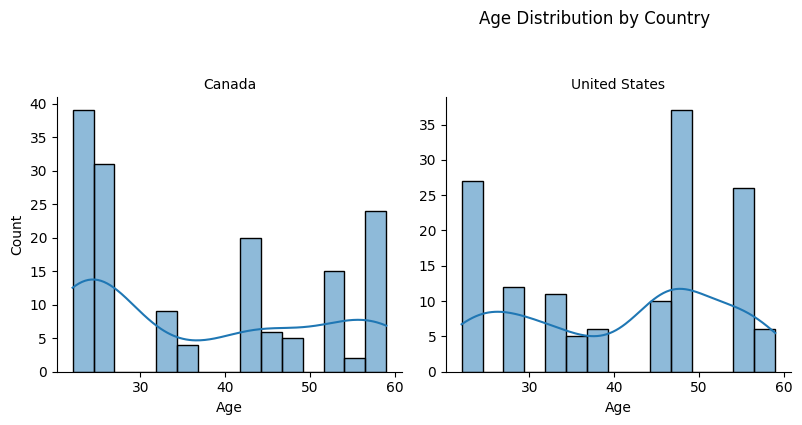

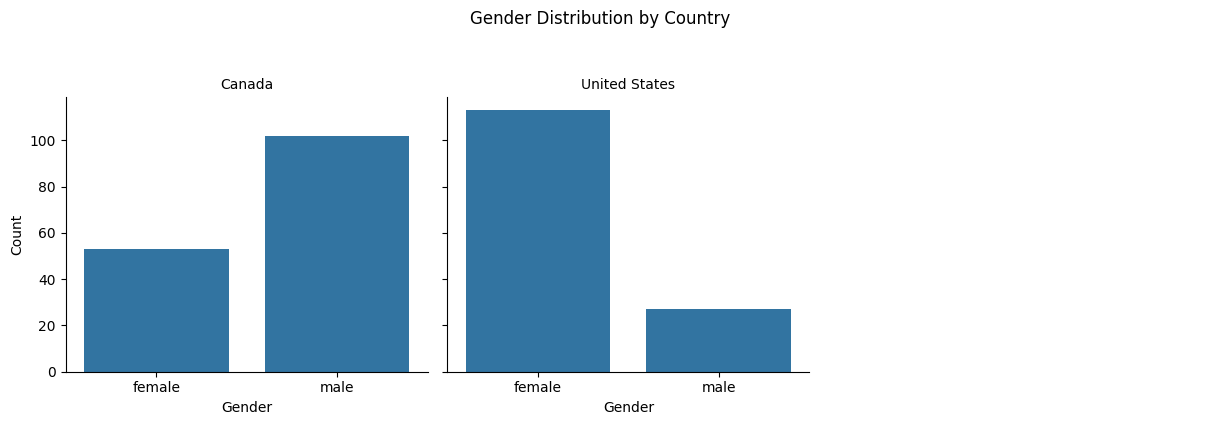

In [241]:
print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()

But this lowers prediction accuracy to ~65%

## Matching with Propensity Scores

In [259]:

def propensity_score_matching(df, treatment_col='Country', treatment='United States'):
    # Calculate propensity scores
    X = df[['Age', 'Gender']].copy()
    X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})  # Convert to numeric
    y = (df[treatment_col] == treatment).astype(int)
    
    # Fit logistic regression to get propensity scores
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df['propensity_score'] = logit.predict_proba(X)[:, 1]
    
    # Separate treatment and control groups
    treatment_df = df[df[treatment_col] == treatment]
    control_df = df[df[treatment_col] != treatment]
    
    # Perform matching (1:1 nearest neighbor matching without replacement)
    nbrs = NearestNeighbors(n_neighbors=1).fit(control_df[['propensity_score']])
    distances, indices = nbrs.kneighbors(treatment_df[['propensity_score']])
    
    # Create matched control group
    matched_control = control_df.iloc[indices.flatten()]
    
    # Combine matched samples
    matched_df = pd.concat([treatment_df, matched_control])
    
    return matched_df

# Apply propensity score matching
matched_df = propensity_score_matching(df)

# Verify balance
print("\nMatched counts:\n", matched_df['Country'].value_counts())

print("\nMatched Age Stats:")
print(matched_df.groupby('Country')['Age'].describe())

print("\nMatched Gender Distribution:")
print(matched_df.groupby('Country')['Gender'].value_counts(normalize=True))


Matched counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Matched Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  39.278571  11.720405  22.0  32.0  43.0  46.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Matched Gender Distribution:
Country        Gender
Canada         female    0.807143
               male      0.192857
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64


In [262]:
def propensity_score_matching(df, treatment_col='Country', treatment='United States'):
    # Calculate propensity scores
    X = df[['Age', 'Gender']].copy()
    X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})  # Convert to numeric
    y = (df[treatment_col] == treatment).astype(int)
    
    # Fit logistic regression to get propensity scores
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df['propensity_score'] = logit.predict_proba(X)[:, 1]
    
    # Separate treatment and control groups
    treatment_df = df[df[treatment_col] == treatment]
    control_df = df[df[treatment_col] != treatment]
    
    # Shuffle both groups to ensure random matching
    treatment_df = treatment_df.sample(frac=1, random_state=42)
    control_df = control_df.sample(frac=1, random_state=42)
    
    # Initialize matched control indices
    matched_control_indices = []
    available_controls = set(control_df.index)
    
    # Perform matching (1:1 nearest neighbor matching without replacement)
    nbrs = NearestNeighbors(n_neighbors=len(control_df)).fit(control_df[['propensity_score']])
    
    for _, treat_row in treatment_df.iterrows():
        # Find distances to all controls
        distances, indices = nbrs.kneighbors([[treat_row['propensity_score']]])
        
        # Find the closest available control
        for idx in indices[0]:
            control_idx = control_df.index[idx]
            if control_idx in available_controls:
                matched_control_indices.append(control_idx)
                available_controls.remove(control_idx)
                break
    
    # Create matched control group
    matched_control = control_df.loc[matched_control_indices]
    
    # Combine matched samples (only matched pairs)
    matched_df = pd.concat([treatment_df.iloc[:len(matched_control)], matched_control])
    
    return matched_df

# Apply propensity score matching
matched_df = propensity_score_matching(df)

# Verify balance
print("\nMatched counts:\n", matched_df['Country'].value_counts())

print("\nMatched Age Stats:")
print(matched_df.groupby('Country')['Age'].describe())

print("\nMatched Gender Distribution:")
print(matched_df.groupby('Country')['Gender'].value_counts(normalize=True))


Matched counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Matched Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  35.564286  13.314249  22.0  24.0  28.5  46.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Matched Gender Distribution:
Country        Gender
Canada         male      0.621429
               female    0.378571
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64


# Incorporating Propensity Score Matching

However this reduces the dataset to just 41 people from each country from the original 140

In [306]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

def propensity_score_matching(df, treatment_col='Country', treatment='United States', caliper=0.1):
    """
    Perform 1:1 propensity score matching with stricter criteria
    
    Parameters:
    - df: DataFrame containing the data
    - treatment_col: Column name indicating treatment/control
    - treatment: Value indicating the treatment group
    - caliper: Maximum allowed distance between matched pairs (in propensity score units)
    
    Returns:
    - Matched DataFrame
    """
    # Calculate propensity scores
    X = df[['Age', 'Gender']].copy()
    X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})  # Convert to numeric
    y = (df[treatment_col] == treatment).astype(int)
    
    # Fit logistic regression to get propensity scores
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df['propensity_score'] = logit.predict_proba(X)[:, 1]
    
    # Separate treatment and control groups
    treatment_df = df[df[treatment_col] == treatment].copy()
    control_df = df[df[treatment_col] != treatment].copy()
    
    # Shuffle both groups to ensure random matching order
    treatment_df = treatment_df.sample(frac=1, random_state=42)
    control_df = control_df.sample(frac=1, random_state=42)
    
    # Initialize storage for matched pairs
    matched_pairs = []
    used_controls = set()
    
    # We'll find the 5 nearest neighbors for each treatment, then pick the best available
    nbrs = NearestNeighbors(n_neighbors=5).fit(control_df[['propensity_score']])
    
    for treat_idx, treat_row in treatment_df.iterrows():
        # Find nearest neighbors in control group
        distances, indices = nbrs.kneighbors([[treat_row['propensity_score']]])
        
        # Check neighbors in order of increasing distance
        for i, (dist, control_idx) in enumerate(zip(distances[0], indices[0])):
            control_row_idx = control_df.index[control_idx]
            
            # Apply caliper - only consider matches within the caliper distance
            if dist > caliper:
                continue
                
            # Check if control is available and has exact matching on gender if needed
            if (control_row_idx not in used_controls and 
                treat_row['Gender'] == control_df.loc[control_row_idx, 'Gender']):
                
                matched_pairs.append((treat_idx, control_row_idx))
                used_controls.add(control_row_idx)
                break  # Move to next treatment after finding a match
    
    # Create matched dataframe
    matched_treatment = df.loc[[pair[0] for pair in matched_pairs]]
    matched_control = df.loc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treatment, matched_control])
    
    print(f"Original treatment count: {len(treatment_df)}")
    print(f"Matched treatment count: {len(matched_treatment)}")
    print(f"Matching rate: {len(matched_treatment)/len(treatment_df):.1%}")
    
    return matched_df

# Apply propensity score matching with stricter criteria
matched_df = propensity_score_matching(df, caliper=0.1)  # Adjust caliper as needed

# Verify balance
print("\nMatched counts:\n", matched_df['Country'].value_counts())

print("\nMatched Age Stats:")
print(matched_df.groupby('Country')['Age'].describe())

print("\nMatched Gender Distribution:")
print(matched_df.groupby('Country')['Gender'].value_counts(normalize=True))

Original treatment count: 140
Matched treatment count: 41
Matching rate: 29.3%

Matched counts:
 Country
United States    41
Canada           41
Name: count, dtype: int64

Matched Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada          41.0  39.121951  12.312991  22.0  32.0  36.0  46.0  59.0
United States   41.0  39.878049  11.960759  22.0  29.0  38.0  47.0  57.0

Matched Gender Distribution:
Country        Gender
Canada         female    0.560976
               male      0.439024
United States  female    0.560976
               male      0.439024
Name: proportion, dtype: float64


Now datasets are balanced and we can implement BERT again


Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         39.121951   36.0  12.312991  22  59   
United States  39.878049   38.0  11.960759  22  57   

                                                          Gender  
                                                        <lambda>  
Country                                                           
Canada         {'female': 0.5609756097560976, 'male': 0.43902...  
United States  {'female': 0.5609756097560976, 'male': 0.43902...  


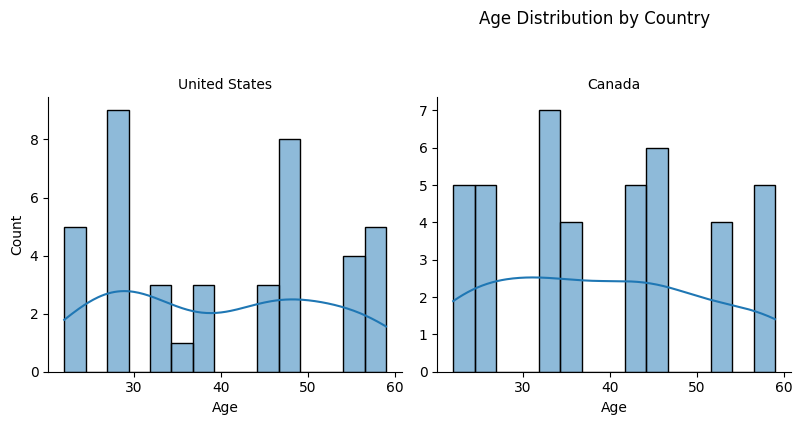

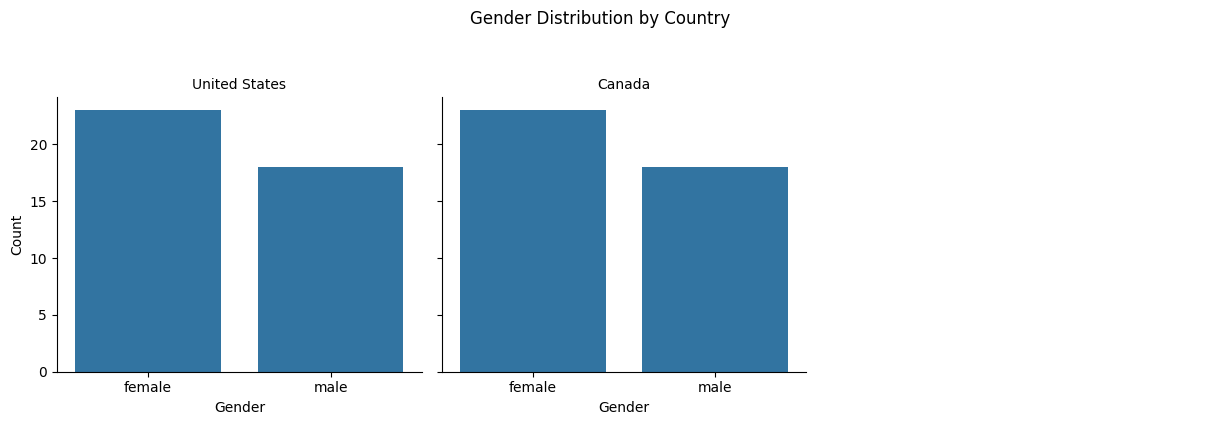

In [311]:

# Add this after your existing preprocessing code
demographic_stats = matched_df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})

print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = matched_df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = matched_df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


In [312]:
import pandas as pd

# Assuming matched_df is your DataFrame
quotes_by_country = matched_df.groupby('Country')['Quote'].unique()

# Display all unique quotes for Canada


# Count statistics
print("\n=== QUOTE COUNTS ===")
print(f"Total Canadian quotes: {len(matched_df[matched_df['Country'] == 'Canada'])}")
print(f"Unique Canadian quotes: {len(quotes_by_country['Canada'])}")
print(f"Total US quotes: {len(matched_df[matched_df['Country'] == 'United States'])}")
print(f"Unique US quotes: {len(quotes_by_country['United States'])}")


=== QUOTE COUNTS ===
Total Canadian quotes: 41
Unique Canadian quotes: 38
Total US quotes: 41
Unique US quotes: 41


In [313]:
random.seed(365)

# Preprocessing
feature_columns = ['Theme', 'Sub-theme', 'Age', 'Gender', 'Quote']  # Added 'Quotes'
target_column = 'Country'

# Convert sparse matrix to dense if needed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender', 'Quote'])  # Added 'Quotes'
    ],
    remainder='passthrough'
)

combined_features = preprocessor.fit_transform(matched_df[feature_columns])
# Convert to dense array if it's sparse (common with OneHotEncoder)
if hasattr(combined_features, 'toarray'):
    combined_features = combined_features.toarray()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(matched_df[target_column])

print("Combined features shape:", combined_features.shape)
print("Encoded labels shape:", encoded_labels.shape)

# XGBoost setup
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        )))
        print("Including XGBoost in the ensemble")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

def safe_cross_val_predict(model, X, y, cv):
    # Always use sequential processing to avoid serialization issues
    return cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=1,
        method='predict_proba',
        verbose=1
    )

def run_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = create_ensemble_model()
    predictions = safe_cross_val_predict(model, X, y, kf)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes, predictions

try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Add probability analysis
    print("\nProbability Analysis:")
    print(f"Average confidence for correct predictions: {np.max(prediction_probs[encoded_labels == predicted_classes]).mean():.4f}")
    print(f"Average confidence for incorrect predictions: {np.max(prediction_probs[encoded_labels != predicted_classes]).mean():.4f}")
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1, method='predict')
    
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Combined features shape: (82, 94)
Encoded labels shape: (82,)
XGBoost 3.0.2 is installed
Including XGBoost in the ensemble

Classification Results:
Accuracy: 0.7927

Classification Report:
               precision    recall  f1-score   support

       Canada       0.80      0.78      0.79        41
United States       0.79      0.80      0.80        41

     accuracy                           0.79        82
    macro avg       0.79      0.79      0.79        82
 weighted avg       0.79      0.79      0.79        82


Confusion Matrix:
[[32  9]
 [ 8 33]]

Probability Analysis:
Average confidence for correct predictions: 0.7991
Average confidence for incorrect predictions: 0.6928


It has 80% accuracy within those 41 people

Now training it on just the matched dataset and testing it on the ones that were not matched before (the other 100 participants), we obtain a prediction accuracy of 85%

In [316]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# First train on the matched data (41 entries)
X_matched = preprocessor.transform(matched_df[feature_columns])
if hasattr(X_matched, 'toarray'):
    X_matched = X_matched.toarray()
y_matched = label_encoder.transform(matched_df[target_column])

# Train final model on matched data
final_model = create_ensemble_model()
final_model.fit(X_matched, y_matched)

# --- Get unseen data (full dataset MINUS training samples) ---

# Create identifier column (assuming you have a unique ID column like 'id')
# If no unique ID exists, create a temporary composite key
matched_ids = matched_df.index if isinstance(matched_df, pd.DataFrame) else matched_df.index.values
full_ids = df.index if isinstance(df, pd.DataFrame) else df.index.values

# Find indices of unseen data
unseen_mask = ~df.index.isin(matched_df.index)
unseen_df = df[unseen_mask]

# Prepare unseen data for evaluation
X_unseen = preprocessor.transform(unseen_df[feature_columns])
if hasattr(X_unseen, 'toarray'):
    X_unseen = X_unseen.toarray()
y_unseen = label_encoder.transform(unseen_df[target_column])

# Evaluate ONLY on unseen data
unseen_predictions = final_model.predict(X_unseen)
unseen_probs = final_model.predict_proba(X_unseen)

# Metrics
print(f"\nEvaluation on Unseen Data ({len(unseen_df)} samples):")
print(f"Accuracy: {accuracy_score(y_unseen, unseen_predictions):.4f}")
print(classification_report(y_unseen, unseen_predictions, 
                          target_names=label_encoder.classes_))

# Optional: Compare with training performance
train_predictions = final_model.predict(X_matched)
print(f"\nTraining Performance ({len(matched_df)} samples):")
print(f"Accuracy: {accuracy_score(y_matched, train_predictions):.4f}")

Including XGBoost in the ensemble

Evaluation on Unseen Data (213 samples):
Accuracy: 0.8592
               precision    recall  f1-score   support

       Canada       0.87      0.87      0.87       114
United States       0.85      0.85      0.85        99

     accuracy                           0.86       213
    macro avg       0.86      0.86      0.86       213
 weighted avg       0.86      0.86      0.86       213


Training Performance (82 samples):
Accuracy: 1.0000


## Feature Importance

Including XGBoost in the ensemble


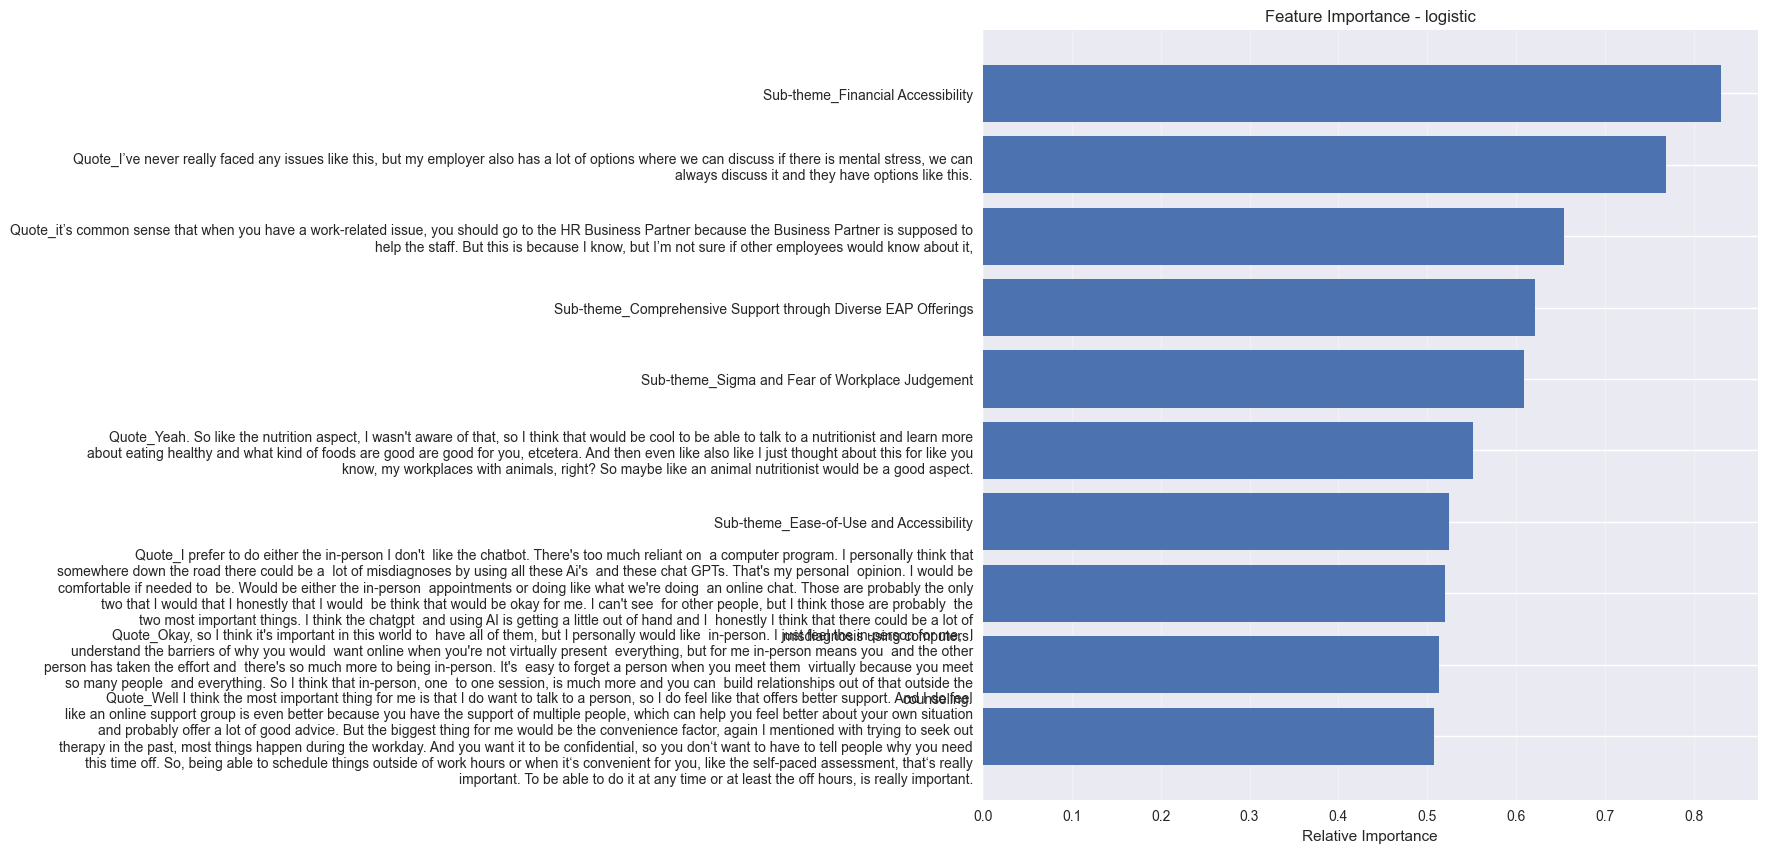

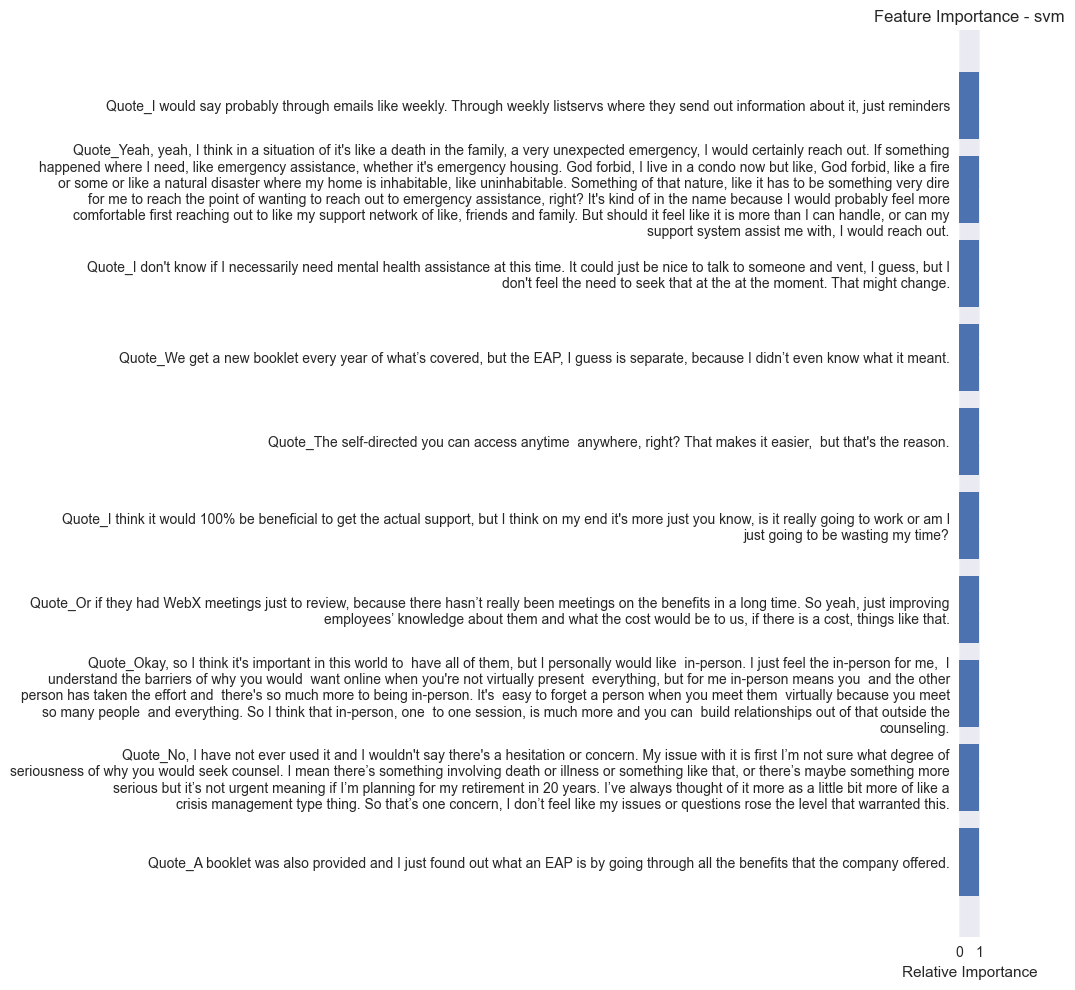

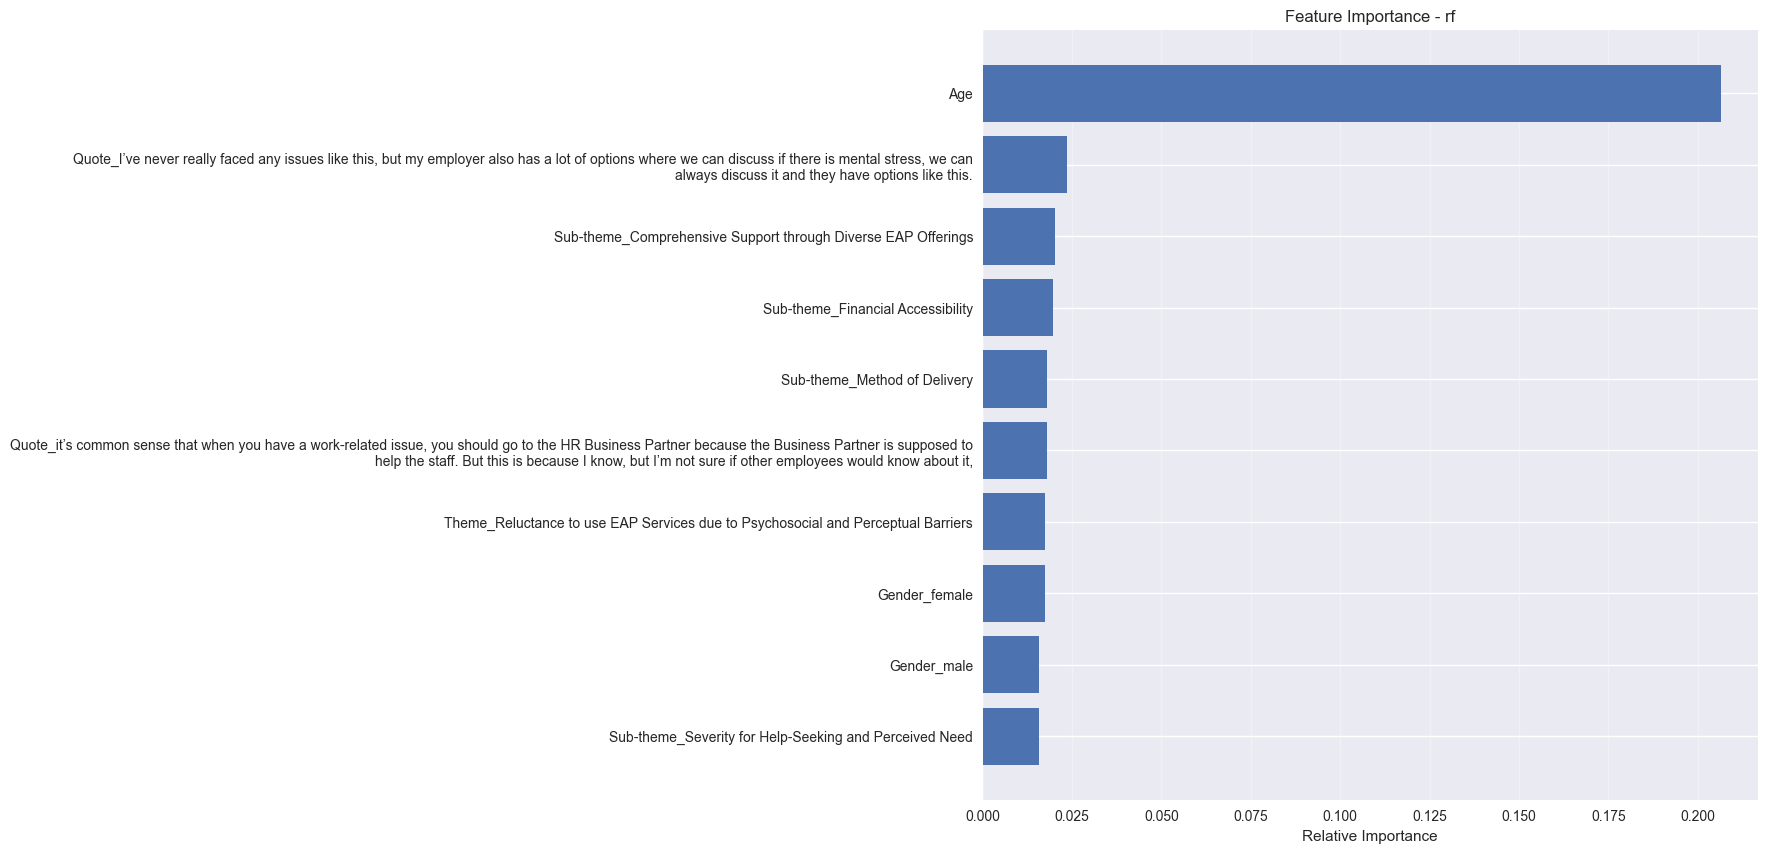

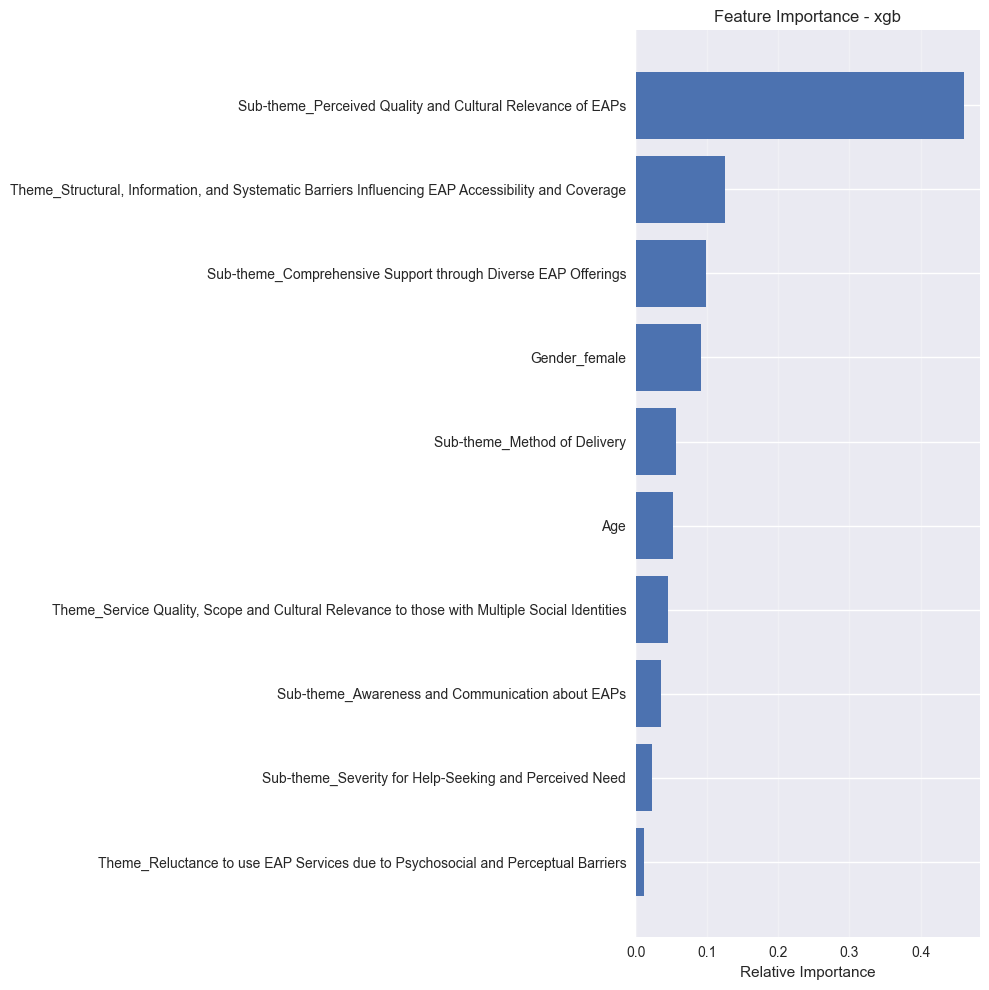

In [336]:
# After training the ensemble model
model = create_ensemble_model()
model.fit(combined_features, encoded_labels)

# Get feature names from the preprocessor
feature_names = (preprocessor.named_transformers_['cat']
                .get_feature_names_out(input_features=['Theme', 'Sub-theme', 'Gender', 'Quote']))
feature_names = np.append(feature_names, 'Age')  # Add remaining features

# Plot feature importance for each model in the ensemble
import textwrap

import textwrap
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(estimator, title):
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_
    elif hasattr(estimator, 'coef_'):
        importances = np.abs(estimator.coef_[0])
    else:
        return
    
    # Function to smartly format feature names
    def format_name(name, wrap_width=150, max_words=20):
        words = name.split('_')  # Split encoded features
        
        # Truncate if more than max_words
        if len(words) > max_words:
            truncated = ' '.join(words[:max_words]) + '...'
            return '\n'.join(textwrap.wrap(truncated, width=wrap_width))
        
        # Otherwise just wrap the full name
        return '\n'.join(textwrap.wrap(name, width=wrap_width))
    
    # Get top 20 features
    indices = np.argsort(importances)[-10:]
    
    # Format feature names
    formatted_names = [format_name(feature_names[i]) for i in indices]
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    bars = plt.barh(range(len(indices)), importances[indices], align='center')
    
    # Set y-tick labels with formatted names
    plt.yticks(range(len(indices)), formatted_names)
    
    # Add full names as tooltips for reference
    for bar, full_name in zip(bars, [feature_names[i] for i in indices]):
        bar.set_label(full_name)
    
    plt.xlabel('Relative Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.gca().set_axisbelow(True)  # Grid behind bars
    plt.tight_layout()
    plt.show()

# Plot for each model in the ensemble
for name, estimator in model.named_estimators_.items():
    plot_feature_importance(estimator, f'Feature Importance - {name}')

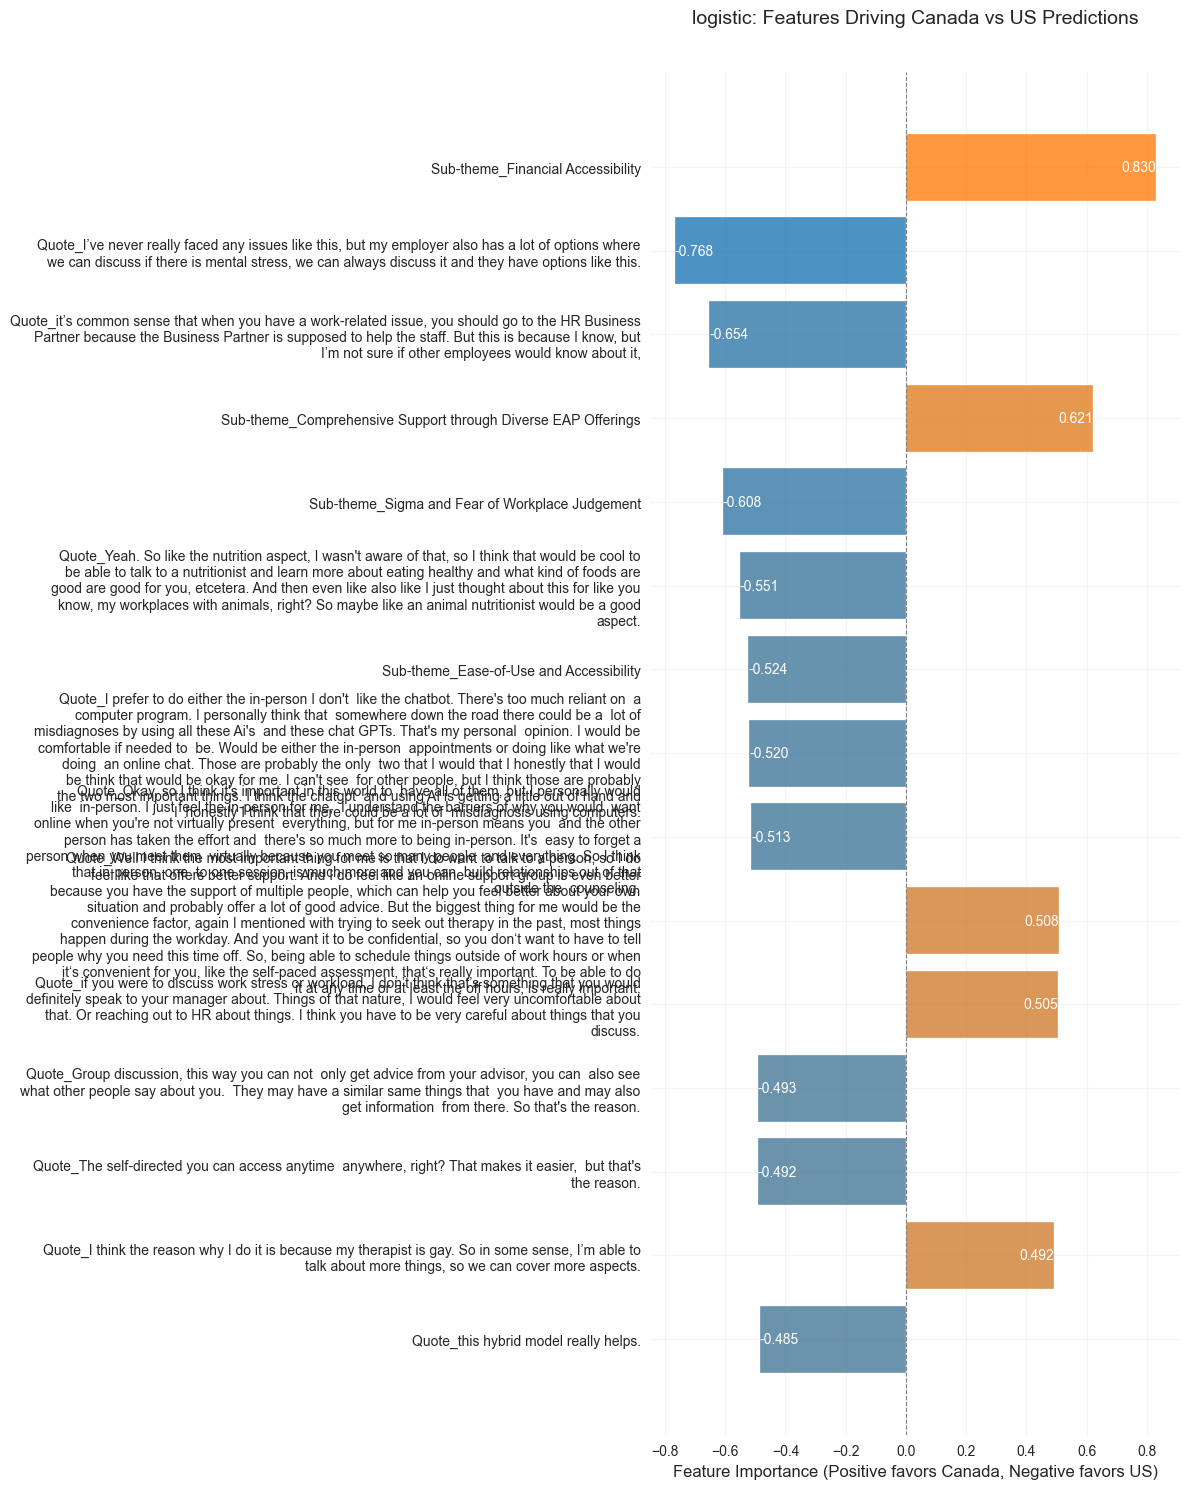

<Figure size 1000x1500 with 0 Axes>

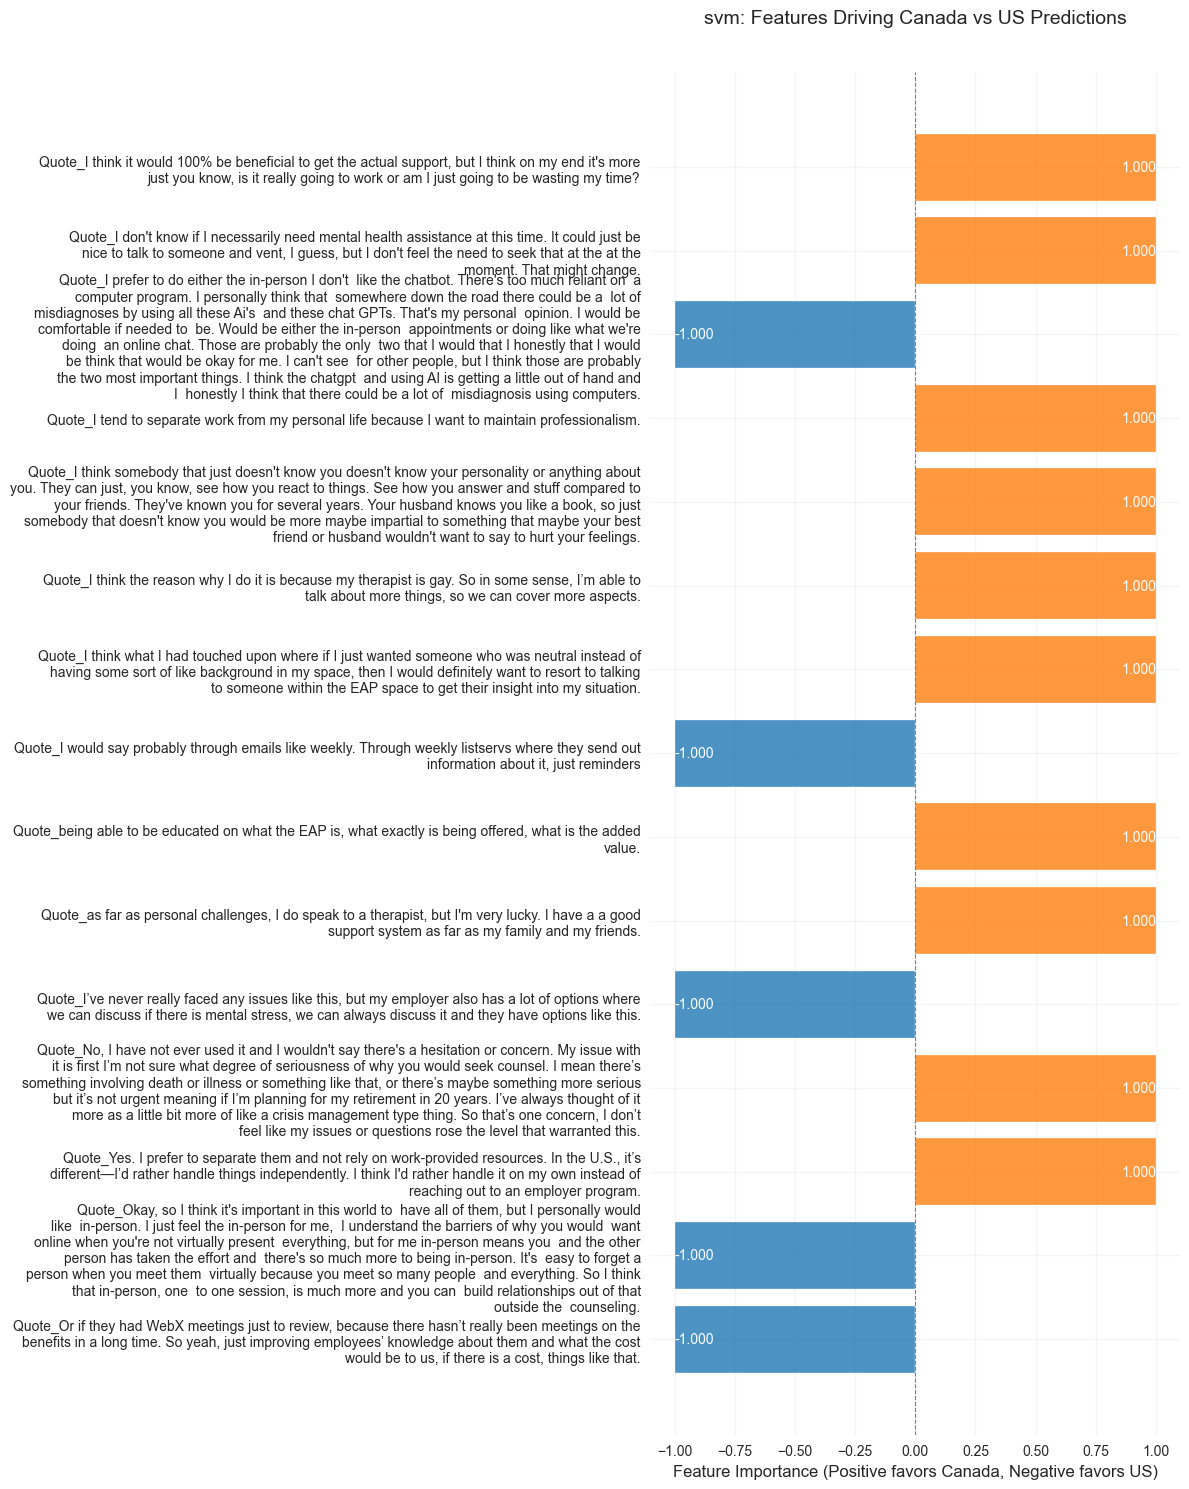

<Figure size 1000x1500 with 0 Axes>

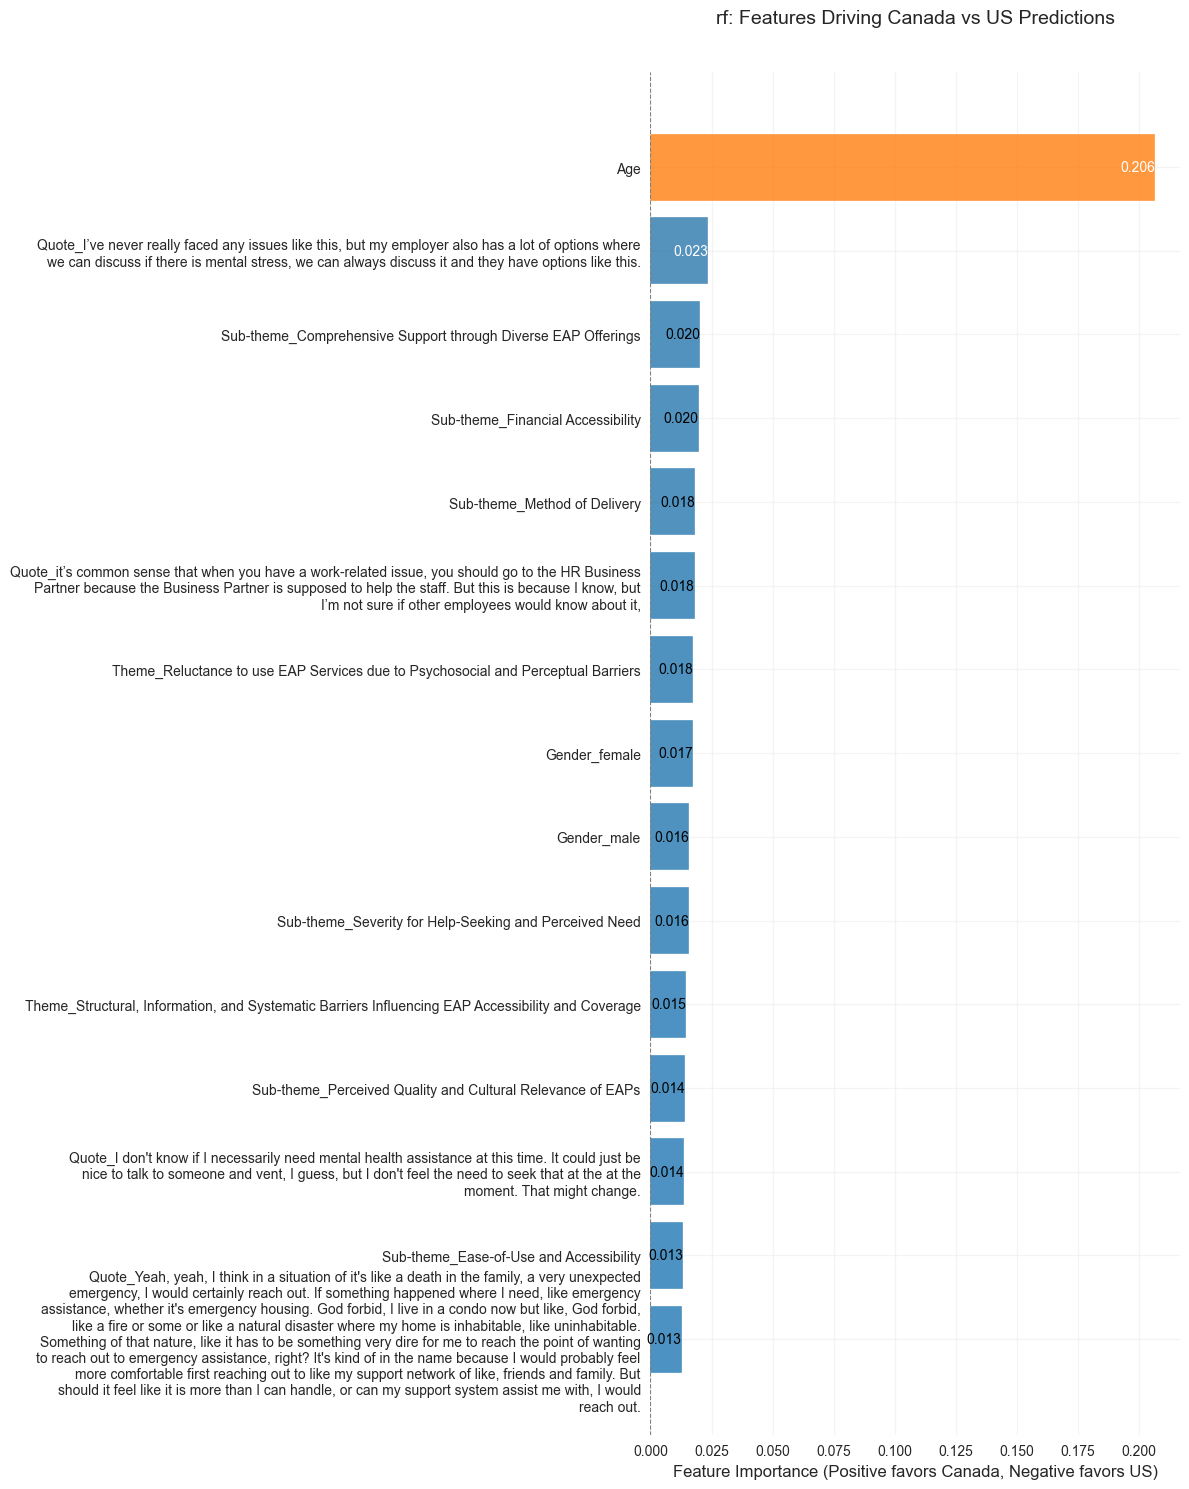

<Figure size 1000x1500 with 0 Axes>

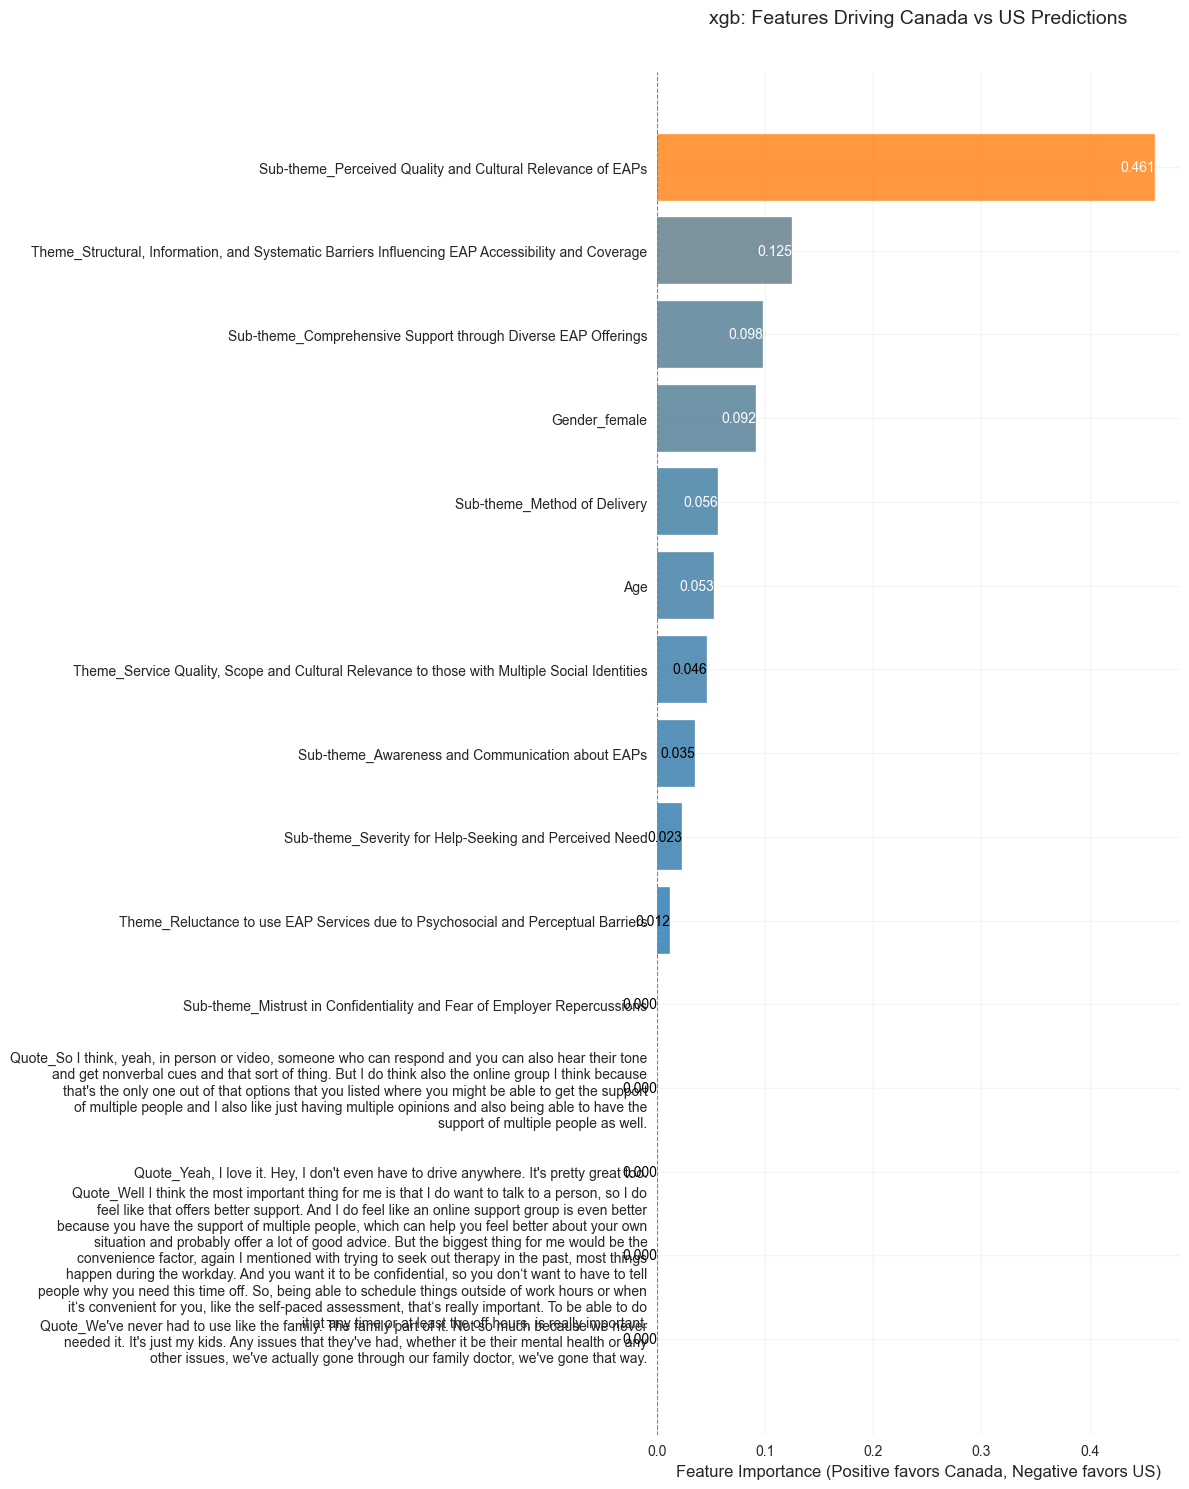

<Figure size 1000x1500 with 0 Axes>

In [356]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textwrap
from matplotlib.colors import LinearSegmentedColormap

def format_name(name, wrap_width=100, max_words=10):
    words = name.split('_')  # Split encoded features
    
    # Truncate if more than max_words
    if len(words) > max_words:
        truncated = ' '.join(words[:max_words]) + '...'
        return '\n'.join(textwrap.wrap(truncated, width=wrap_width))
    
    # Otherwise just wrap the full name
    return '\n'.join(textwrap.wrap(name, width=wrap_width))

def plot_country_driving_features(estimator, model_name, feature_names, n_features=15):
    """
    Creates a professional horizontal bar plot showing features that drive
    Canada vs US predictions, with color-coding by direction.
    """
    # Get Canada importance scores (positive favors Canada, negative favors US)
    canada_idx = list(label_encoder.classes_).index('Canada')
    
    if hasattr(estimator, 'coef_'):
        importance = estimator.coef_[canada_idx]
    elif hasattr(estimator, 'feature_importances_'):
        importance = estimator.feature_importances_
    else:
        print(f"No importance scores available for {model_name}")
        return
    
    # Create dataframe and sort
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', key=abs, ascending=False).head(n_features)
    
    # Format feature names
    df['Formatted_Feature'] = df['Feature'].apply(lambda x: format_name(x))
    
    # Create figure with manual styling
    fig, ax = plt.subplots(figsize=(12, 15))
    
    # Set manual style properties
    plt.rcParams.update({
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.color': '#dddddd',
        'axes.axisbelow': True,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'ytick.labelsize': 10  # Smaller font for y-axis
    })
    
    # Create color gradient (blue to orange)
    cmap = LinearSegmentedColormap.from_list('country', ['#1F77B4', '#FF7F0E'])
    colors = cmap((df['Importance'] - df['Importance'].min()) / 
               (df['Importance'].max() - df['Importance'].min()))
    
    # Plot bars using formatted feature names
    bars = ax.barh(df['Formatted_Feature'], df['Importance'], color=colors, alpha=0.8, edgecolor='white')
    
    # Add styling
    ax.set_title(f'{model_name}: Features Driving Canada vs US Predictions\n', pad=20)
    ax.set_xlabel('Feature Importance (Positive favors Canada, Negative favors US)')
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add value labels
    for bar, importance in zip(bars, df['Importance']):
        width = bar.get_width()
        align = 'left' if width < 0 else 'right'
        color = 'black' if abs(width) < 0.1*max(df['Importance'].abs()) else 'white'
        ax.text(width, bar.get_y() + bar.get_height()/2, 
               f'{importance:.3f}', 
               ha=align, va='center', color=color, fontsize=10)
    
    # Adjust layout
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.tight_layout()
    plt.figure(figsize=(10, 15))

    plt.show()

# Generate plots for all models in your ensemble
for model_name, estimator in model.named_estimators_.items():
    plot_country_driving_features(estimator, model_name, feature_names)